This notebook shows how to translate CODEX features to gene expression with a trained OT Flow Matching model and gene expression decoder. Before running the notebooks, make sure you follow these steps: 
* Download the data in `scPortrait_manuscript/input_data/CITEseq_tonsil_reference_dataset` and `scPortrait_manuscript/input_data/CODEX_tonsil_healthy_tonsilitis` and process them.
* Run the previous notebooks in `00_codex_and_citeseq_preprocessing.ipynb` and `01_codex_feature_standardization.ipynb`.
* Download the checkpoint files `flow_matching.ckpt` and `gene_decoder.ckpt` from the Zenodo folder. Create a `checkpoint` folder in the same directory of this notebook and place the two checkpoints there.
* Make sure a folder `generated_files` is present in the same directory as this notebook.  

In [2]:
# Configuration for neural network
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import numpy as np
import pandas as pd
import scanpy as sc
import torch
from torch.utils.data import Dataset, DataLoader

#Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Software
import scportrait_ot
from scportrait_ot.dataloader import SingleCellAndCodexDataset 
from scportrait_ot.model import FlowMatchingModelWrapper

plt.rcParams['figure.figsize'] = (3, 3) 

Initialize configuration dict

In [3]:
with initialize(config_path="configs/"):
    # Step 2: Compose the configuration
    config_dict = compose(config_name="train",
                          overrides=["datamodule=tonsilitis_cite"])  

/tmp/ipykernel_369160/3048285057.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="configs/"):


Model

In [4]:
dataset = SingleCellAndCodexDataset(config_dict.datamodule.rna_adata_path, 
                                        config_dict.datamodule.codex_adata_path, 
                                        config_dict.datamodule.label_columns, 
                                        config_dict.datamodule.obsm_key_rna, 
                                        config_dict.datamodule.obsm_key_codex) 

In [5]:
model = FlowMatchingModelWrapper(input_dim=dataset.input_dim,
                                    hidden_dim=config_dict.model.hidden_dim,
                                    num_hidden_layers=config_dict.model.num_hidden_layers,
                                    time_embedding_dim=config_dict.model.time_embedding_dim,
                                    source_condition_dim=dataset.source_dim, 
                                    use_batchnorm=config_dict.model.use_batchnorm,
                                    sigma=config_dict.model.sigma, 
                                    flavor=config_dict.model.flavor, 
                                    learning_rate=config_dict.model.learning_rate, 
                                    weight_decay=config_dict.model.weight_decay, 
                                    distance=config_dict.model.distance)

Checkpoints

## Collect trained model

In [6]:
ckpts = torch.load("checkpoints/flow_matching.ckpt")

In [7]:
model.load_state_dict(ckpts["state_dict"])

<All keys matched successfully>

### Read CODEX data

In [8]:
codex_dir = Path("../../input_data/CODEX_tonsil_healthy_tonsilitis/processed_data")
adata_codex = sc.read_h5ad(codex_dir / "cellfeaturization_results_tonsilitis_processed_std.h5ad")

### Read CITE-seq data

In [9]:
cite_dir = Path("../../input_data/CITEseq_tonsil_reference_dataset/processed_data")
adata_scrnaseq = sc.read_h5ad(cite_dir / "CITEseq_protein_processed.h5ad")

## Pushforward 

Implement torch dataseta and cluster assignment function

In [10]:
# Step 1: Wrap the CODEX data in a PyTorch Dataset
class CodexDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data.X).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Step 2: Define cluster assignment via nearest neighbors
def cluster_assignment(X_hat, X_true, true_annot, n_neighs=1):
    nn_model = KNeighborsClassifier(n_neighbors=n_neighs, algorithm='auto')
    nn_model.fit(X_true, true_annot)
    indices = nn_model.predict(X_hat)
    return indices

Iterate over CODEX samples and predict their RNA HARMONY embeddings

In [11]:
# Step 3: Prepare data and loader
codex_dataset = CodexDataset(adata_codex)
codex_loader = DataLoader(codex_dataset, batch_size=1000, shuffle=False)

real_annot = np.array(adata_scrnaseq.obs.annotation_figure_1)
X_true = adata_scrnaseq.obsm["X_harmony_RNA"]  # assumed (n_cells_rna, n_features)

# Step 4: Run inference and assignment in batches
assigned_annots = []
X_harmony_hat = []

for batch in codex_loader:
    X_codex = batch  # already a torch tensor
    X_rna_hat = model.pushforward(
        x0=X_codex,
        n_timesteps=2,
        solver="dopri5"
    ).detach().cpu().numpy()

    batch_annots = cluster_assignment(X_rna_hat, X_true, real_annot, n_neighs=5)
    
    assigned_annots.append(batch_annots)
    X_harmony_hat.append(X_rna_hat)
    
# Step 5: Concatenate all annotations
assigned_annots = np.concatenate(assigned_annots)
X_harmony_hat = np.concatenate(X_harmony_hat, axis=0)

adata_codex.obs["cell_type"] = assigned_annots
adata_codex.obsm["predicted_harmony"] = X_harmony_hat

Examine results

In [12]:
sc.tl.pca(adata_codex)
sc.pp.neighbors(adata_codex)
sc.tl.umap(adata_codex)

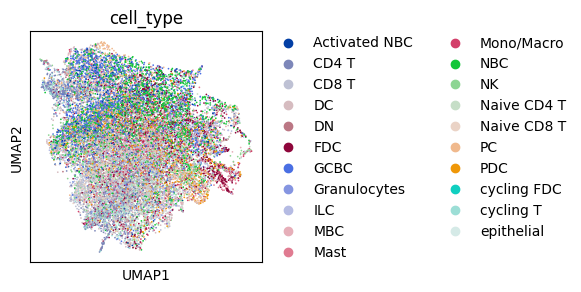

In [13]:
sc.pl.umap(adata_codex,color="cell_type")

## Add decoded gene expression

In [14]:
from scportrait_ot.dataloader import EmbeddingDecoderDataset
from scportrait_ot.decoding_modules import DecoderFromHarmony

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [16]:
dataset = EmbeddingDecoderDataset(adata_path="generated_files/CITEseq_rna_processed_full_genome.h5ad", 
                                     count_label="X_normalized_log", 
                                     embedding_label="X_harmony_RNA",
                                     batch_label="donor_id")

In [17]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3, 
                                   likelihood="gaussian"
                                  )

decoder_model.load_state_dict(torch.load("checkpoints/gene_decoder.ckpt")["state_dict"])

<All keys matched successfully>

In [18]:
with torch.no_grad():
    X_hat = decoder_model.decoder(torch.from_numpy(adata_codex.obsm["predicted_harmony"]))

In [19]:
adata_codex.obsm["X_gexp_log_whole_genome"] = X_hat.detach().cpu().numpy()
adata_codex

AnnData object with n_obs × n_vars = 19784 × 31
    obs: 'scportrait_cell_id', 'region', 'shared_leiden_cluster_id', 'cell_type'
    var: 'feature_name'
    uns: 'spatialdata_attrs', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'predicted_harmony', 'X_pca', 'X_umap', 'X_gexp_log_whole_genome'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Add var names 

In [20]:
adata_cite = sc.read_h5ad(cite_dir / "CITEseq_rna.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [21]:
list(adata_cite.var.index)

['ISG15',
 'TNFRSF4',
 'TAS1R1',
 'UTS2',
 'TNFRSF9',
 'RERE-AS1',
 'SLC2A5',
 'SRM',
 'MTOR',
 'TNFRSF1B',
 'TMEM51',
 'LINC01783',
 'PLA2G2D',
 'UBXN10-AS1',
 'ALPL',
 'C1QA',
 'C1QC',
 'C1QB',
 'ZNF436-AS1',
 'ID3',
 'CLIC4',
 'AL031280.1',
 'STMN1',
 'AL391650.1',
 'ZNF683',
 'HMGN2',
 'FGR',
 'FABP3',
 'MARCKSL1',
 'CLSPN',
 'COL8A2',
 'AL591845.1',
 'CSF3R',
 'CDCA8',
 'HEYL',
 'MYCL',
 'CTPS1',
 'SLFNL1',
 'HIVEP3',
 'CDC20',
 'B4GALT2',
 'SLC6A9',
 'KIF2C',
 'MAST2',
 'RAD54L',
 'STIL',
 'ZYG11A',
 'NDC1',
 'ACOT11',
 'PLPP3',
 'L1TD1',
 'AL513493.1',
 'IL23R',
 'DEPDC1',
 'IFI44L',
 'LINC01781',
 'HS2ST1',
 'GBP1',
 'GBP2',
 'GBP4',
 'GBP5',
 'GFI1',
 'VCAM1',
 'S1PR1',
 'LINC01709',
 'NTNG1',
 'GPSM2',
 'KIAA1324',
 'PSRC1',
 'AMIGO1',
 'CHI3L2',
 'CTTNBP2NL',
 'RHOC',
 'IGSF3',
 'CD2',
 'CD101',
 'TENT5C',
 'PHGDH',
 'CD160',
 'AC239799.2',
 'HIST2H2BF',
 'HIST2H3D',
 'HIST2H2AA4',
 'HIST2H2BE',
 'HIST2H2AC',
 'HIST2H2AB',
 'SV2A',
 'C1orf54',
 'ECM1',
 'ANXA9',
 'CGN',
 'RO

In [22]:
adata_codex.uns["var_names_whole_genome"] = list(adata_cite.raw.var.index)

In [23]:
len(adata_codex.uns["var_names_whole_genome"])

17288

In [24]:
adata_codex.write_h5ad("generated_files/predicted_ct_tonsilitis_decoded.h5ad")